In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from spectral import imshow, view_cube
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import spectral.io.envi as envi

In [3]:
date_dir = '11032019'
num = '1'

dark_ref = envi.open('./{}/dark_ref/capture/dark_ref.hdr'.format(date_dir), './{}/dark_ref/capture/dark_ref.raw'.format(date_dir))
white_ref = envi.open('./{}/white_ref/capture/white_ref.hdr'.format(date_dir), './{}/white_ref/capture/white_ref.raw'.format(date_dir))
data_ref = envi.open('./{}/bisbul_{}_cut/capture/bisbul_{}_cut.hdr'.format(date_dir, num, num), './{}/bisbul_{}_cut/capture/bisbul_{}_cut.raw'.format(date_dir, num, num))

Header parameter names converted to lower case.
Header parameter names converted to lower case.
Header parameter names converted to lower case.


ImageView object:
  Display bands       :  (64, 55, 19)
  Interpolation       :  <default>
  RGB data limits     :
    R: [308.0, 742.0]
    G: [303.0, 695.0]
    B: [237.0, 328.0]

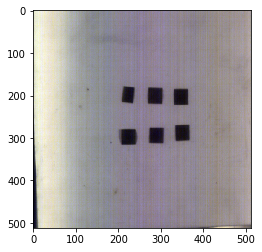

In [4]:
#imshow(data_ref, (110, 5, 18))
white_nparr = np.array(white_ref.load())
dark_nparr = np.array(dark_ref.load())
data_nparr = np.array(data_ref.load())

imshow(data_nparr, (64, 55, 19))

In [5]:
corrected_nparr = np.divide(
    np.subtract(data_nparr, dark_nparr), 
    np.subtract(white_nparr, dark_nparr))

ImageView object:
  Display bands       :  (32, 32, 32)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.14049586653709412, 1.3934426307678223]
    G: [0.14049586653709412, 1.3934426307678223]
    B: [0.14049586653709412, 1.3934426307678223]

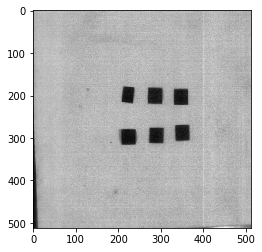

In [6]:
imshow(corrected_nparr, (32, 32, 32))

ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.1344902366399765, 1.6076923608779907]
    G: [0.1344902366399765, 1.6076923608779907]
    B: [0.1344902366399765, 1.6076923608779907]

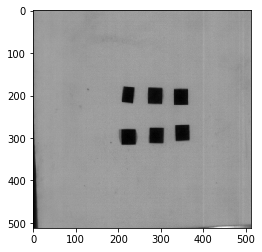

In [7]:
imshow(corrected_nparr, (100, 100, 100))

ImageView object:
  Display bands       :  (200, 200, 200)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.15229885280132294, 1.882882833480835]
    G: [0.15229885280132294, 1.882882833480835]
    B: [0.15229885280132294, 1.882882833480835]

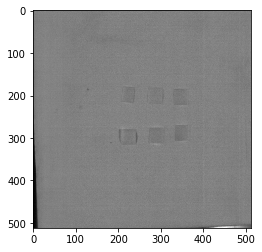

In [8]:
imshow(corrected_nparr, (200, 200, 200))

In [9]:
from numpy import genfromtxt

bands = genfromtxt('./helpers/bands.csv', delimiter=',')

In [10]:
leaf_pixel_y = 125
leaf_pixel_x = 200
teflon_pixel_y = 30
teflon_pixel_x = 450

leaf_pixel = corrected_nparr[
    leaf_pixel_y:leaf_pixel_y+1, 
    leaf_pixel_x:leaf_pixel_x+1, 
    :]
teflon_pixel = corrected_nparr[
    teflon_pixel_y:teflon_pixel_y+1, 
    teflon_pixel_x:teflon_pixel_x+1, 
    :]

leaf_pixel_squeezed = np.squeeze(leaf_pixel)
teflon_pixel_squeezed = np.squeeze(teflon_pixel)

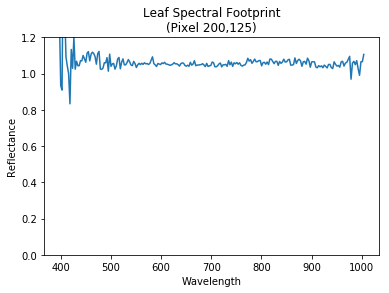

In [11]:
plt.plot(bands, leaf_pixel_squeezed)
plt.ylim(0, 1.2)
plt.title('Leaf Spectral Footprint\n(Pixel {},{})'.format(
    leaf_pixel_x, leaf_pixel_y))
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.show()

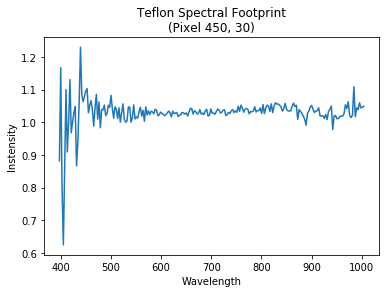

In [12]:
plt.plot(bands, teflon_pixel_squeezed)
plt.title('Teflon Spectral Footprint\n(Pixel {}, {})'.format(
    teflon_pixel_x, teflon_pixel_y))
plt.xlabel('Wavelength')
plt.ylabel('Instensity')
plt.show()

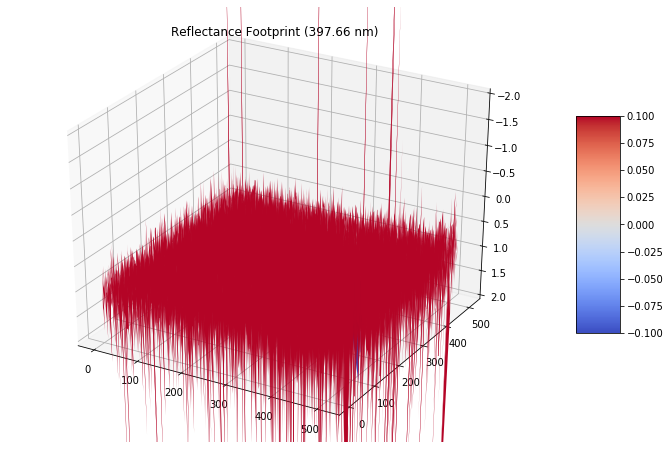

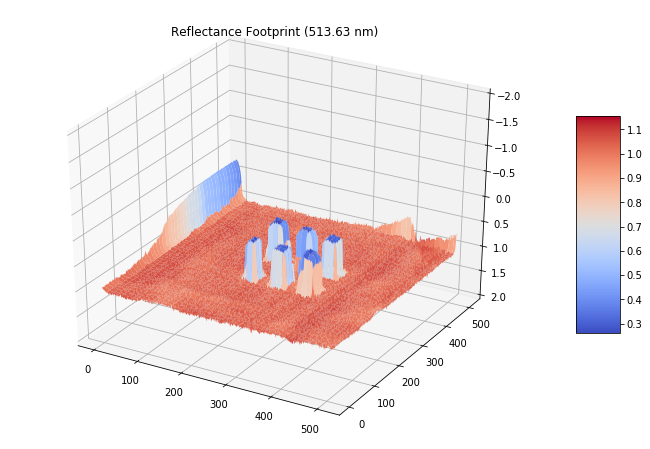

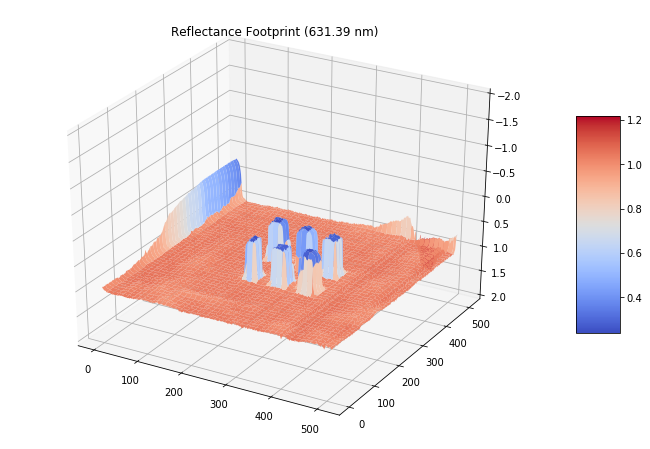

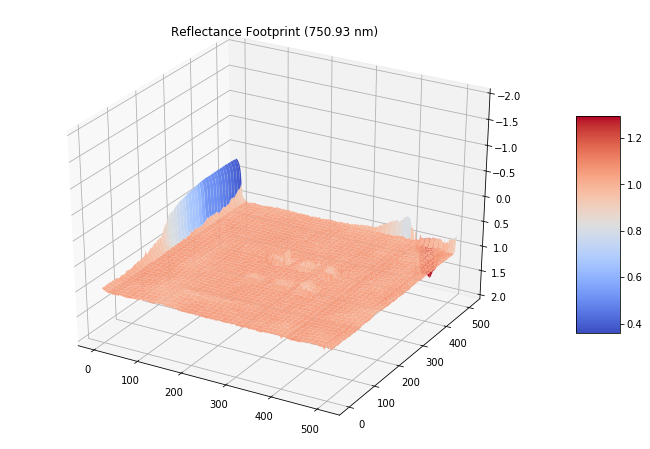

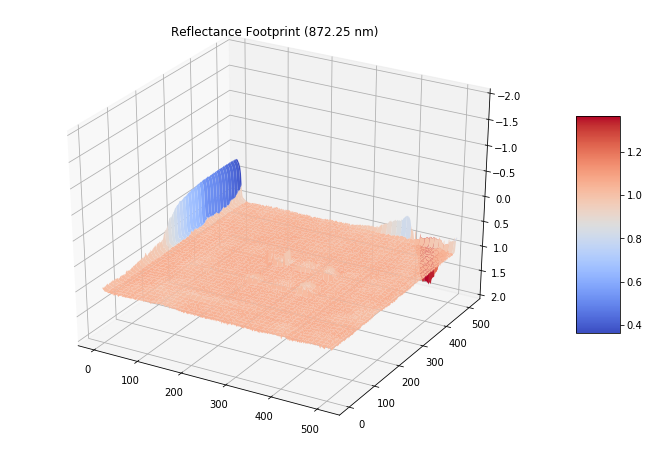

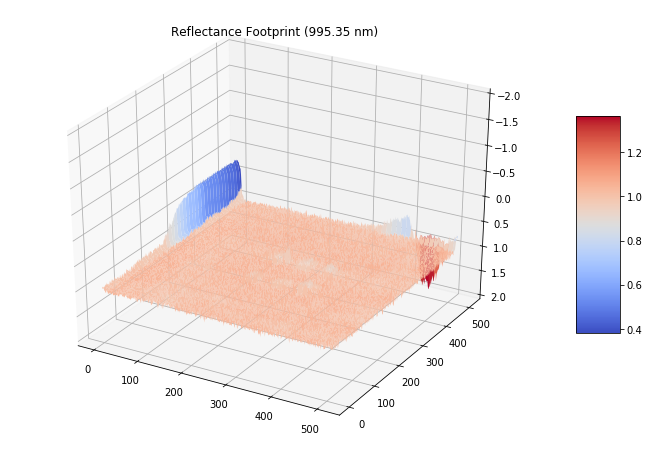

In [13]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

for band in range(0, 224, 44):
    X = np.arange(0, 512, 1)
    Y = np.arange(0, 512, 1)
    X, Y = np.meshgrid(X, Y)
    Z = corrected_nparr[:, :, band]
    (X.shape, Y.shape, Z.shape)

    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=True)
    ax.set_zlim(-2, 2)
    ax.invert_zaxis()
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title('Reflectance Footprint ({} nm)'.format(bands[band]))
    plt.show()

ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.1344902366399765, 2.0]
    G: [0.1344902366399765, 2.0]
    B: [0.1344902366399765, 2.0]

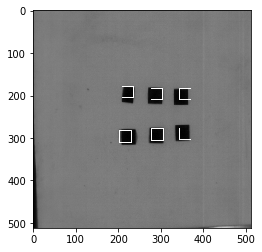

In [14]:
def extract_roi(arr, x, y, w, h, intensity, line):
    roi = arr[y:y+h, x:x+w, :]
    
    bounding_box = arr
    bounding_box[y-line:y, x-line:x+w+line, :] = intensity # garis atas
    bounding_box[y:y+h, x-line:x, :] = intensity # garis kiri
    bounding_box[y+h:y+h+line, x-line:x+w+line, :] = intensity # garis bawah
    bounding_box[y:y+h, x+w:x+w+line, :] = intensity # garis kanan
    
    return (roi, bounding_box)

coordinates = [
    (210, 180),
    (278, 185),
    (345, 185),
    (205, 285),
    (280, 280),
    (345, 278)]

rois = [] # returned ROIs
length = 25 # width and height
intensity = 2 # bounding box line intensity
line = 2 # bounding box line width

bounding_boxed = [] 
bounding_boxed = corrected_nparr

for coordinate in coordinates:
    (x, y) = coordinate
    (roi, bounding_boxed) = extract_roi(
        bounding_boxed, x, y, length, length, intensity, line)
    rois.append(roi)

imshow(bounding_boxed, (100, 100, 100))

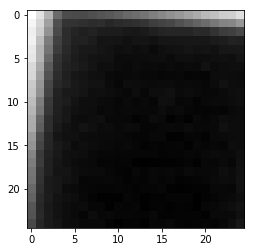

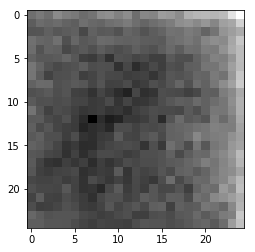

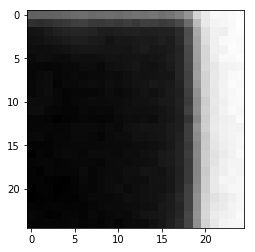

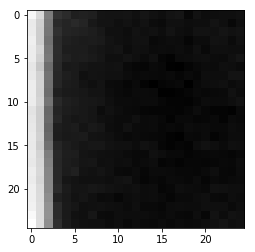

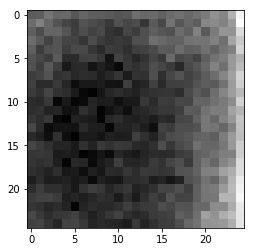

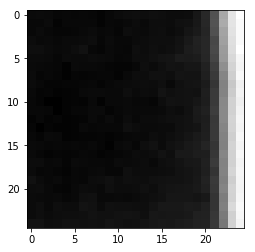

In [15]:
for item in rois:
    imshow(item, (100, 100, 100))

In [16]:
np.save("{}/bisbul_{}_rois.npy".format(date_dir, num), rois)
np.save("{}/bisbul_{}_corrected.npy".format(date_dir, num), corrected_nparr)

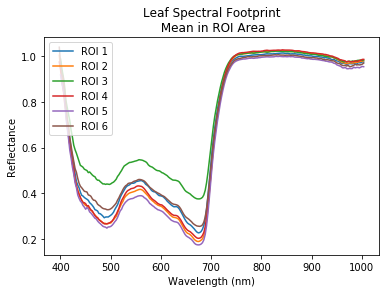

In [17]:
for i in range(len(rois)):
    roi = rois[i]
    intensity = []
    for b in range(roi.shape[2]):
        intensity.append(np.mean(roi[:, :, b]))
    plt.plot(bands, intensity, label='ROI {}'.format(i+1))
    
plt.legend(loc='upper left')
plt.title('Leaf Spectral Footprint\n Mean in ROI Area')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.show()